In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# TensorFlow Model Analysis in Beam

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/tfma_beam.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/tfma_beam.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


[TensorFlow Model Analysis (TFMA)](https://www.tensorflow.org/tfx/guide/tfma) is a library for performing model evaluation across different slices of data. TFMA performs its computations in a distributed manner over large quantities of data by using Apache Beam.

This example notebook shows how you can use TFMA to investigate and visualize the performance of a model as part of your Apache Beam pipeline by creating and comparing two models. This example uses [ExtractEvaluateAndWriteResults](https://www.tensorflow.org/tfx/model_analysis/api_docs/python/tfma/ExtractEvaluateAndWriteResults), which is a `PTransform` that performs extraction and evaluation and writes results all in one step.

TFMA enables scalable and flexible execution of your evaluation pipeline. For additional information about TFMA, see the [TFMA basic notebook](https://www.tensorflow.org/tfx/tutorials/model_analysis/tfma_basic), which provides an in-depth look at TFMA capabilities.

## Install Jupyter extensions
If you are running this example in a local Jupyter notebook, before running Jupyter, you must install these Jupyter extensions in the environment.

```bash
jupyter nbextension enable --py widgetsnbextension --sys-prefix 
jupyter nbextension install --py --symlink tensorflow_model_analysis --sys-prefix 
jupyter nbextension enable --py tensorflow_model_analysis --sys-prefix 
```

##  Install TFMA

Installing TFMA pulls in all of the dependencies. The installation takes about a minute.

In [ ]:
# Upgrade pip to the latest version, and then install TFMA.
!pip install -U pip
!pip install tensorflow-model-analysis

# To use the newly installed version of pip, restart the runtime.
exit() 

In [ ]:
# This configuration was tested in Colab with TensorFlow 2.11, TFMA 0.43, and Apache Beam 2.44.
# The setup is also compatible with the current release.
import sys

# Confirm that you're using Python 3.
assert sys.version_info.major==3, 'This notebook must be run using Python 3.'

import tensorflow as tf
print('TF version: {}'.format(tf.__version__))
import apache_beam as beam
print('Beam version: {}'.format(beam.__version__))
import tensorflow_model_analysis as tfma
print('TFMA version: {}'.format(tfma.__version__))
import tensorflow_datasets as tfds
print('TFDS version: {}'.format(tfds.__version__))

**Note:** Before proceeding, verify that the output does not have errors. If errors occur, re-run the installation, and restart your kernel.

## Preprocess data

This section includes the steps for preprocessing your data.

### Create a diamond price prediction model

This example uses the [TFDS diamonds dataset](https://www.tensorflow.org/datasets/catalog/diamonds) to train a linear regression model that predicts the price of a diamond. This dataset contains various physical attributes of the diamonds, such as the weight (carat), cut quality, color, and clarity, as well as the price of 53,940 diamonds. The model's performance is evaluated using metrics such as mean squared error and mean absolute error.

To simulate a scenario where a model's performance improves over time as new data is added to the dataset, first use half of the diamond dataset to train a model called v1. Then, use additional data to train a second model called v2. These steps demonstrate the use of TFMA when comparing the performance of two models for the same task.

In [ ]:
# Load the data from TFDS and then split the dataset into parts to create train, test, and validation datasets.
(ds_train_v1, ds_test, ds_val), info = tfds.load('diamonds', split=['train[:40%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True, with_info=True)

In [ ]:
import numpy as np

# Load the numerical training data to use for normalization.
def extract_numerical_features(item):
  carat = item['carat']
  depth = item['depth']
  table = item['table']
  x = item['x']
  y = item['y']
  z = item['z']
  
  return [carat, depth, table, x, y, z]

def get_train_data(ds_train):
  train_data = []
  for item, label in ds_train:
    features = extract_numerical_features(item)
    train_data.append(features)

  train_data = np.array(train_data)

  return train_data

In [ ]:
train_data_v1 = get_train_data(ds_train_v1)

In [ ]:
# Define the length of the features.
NUMERICAL_FEATURES = 6
NUM_FEATURES = (NUMERICAL_FEATURES +
                info.features['features']['color'].num_classes +
                info.features['features']['cut'].num_classes +
                info.features['features']['clarity'].num_classes)

In [ ]:
# To transform the input data into a feature vector and label, select the input and output for the model.
def transform_data(item, label):
  numerical_features = extract_numerical_features(item)

  # Categorical features are encoded using one-hot encoding.
  color = tf.one_hot(item['color'], info.features['features']['color'].num_classes)
  cut = tf.one_hot(item['cut'], info.features['features']['cut'].num_classes)
  clarity = tf.one_hot(item['clarity'], info.features['features']['clarity'].num_classes)
  
  # Create the output tensor.
  output = tf.concat([tf.stack(numerical_features, axis=0), color, cut, clarity], 0)
  return output, [label]

In [ ]:
ds_train_v1 = ds_train_v1.map(transform_data)
ds_test = ds_test.map(transform_data)
ds_val = ds_val.map(transform_data)

In [ ]:
# To prepare the data for training, structure it in batches.
BATCH_SIZE = 32
ds_train_v1 = ds_train_v1.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

### Create TFRecords

TFMA and Apache Beam need to read the dataset used during evaluation from a file. Create a `TFRecords` file that contains the validation dataset.

In [ ]:
!mkdir data

In [ ]:
# Write the validation record to a file, which is used by TFMA.
tfrecord_file = 'data/val_data.tfrecord'

with tf.io.TFRecordWriter(tfrecord_file) as file_writer:
  for x, y in ds_val:
    record_bytes = tf.train.Example(features=tf.train.Features(feature={
        "inputs": tf.train.Feature(float_list=tf.train.FloatList(value=x)),
        "output": tf.train.Feature(float_list=tf.train.FloatList(value=[y])),
    })).SerializeToString()
    file_writer.write(record_bytes)

## Define and train one model

Train a linear regression model that predicts the price of a diamond. The model is a neural network with one hidden layer. The model also uses a normalization layer to scale all of the numerical features between 0 and 1.

In [ ]:
def construct_model(model_name, train_data):
  inputs = tf.keras.Input(shape=(NUM_FEATURES,), name='inputs')

  # Normalize the numerical features.
  normalization_layer = tf.keras.layers.Normalization()
  # Fit the normalization layer to the training data.
  normalization_layer.adapt(train_data)
  # Split the input between numerical and categorical input.
  input_numerical = tf.gather(inputs, indices=[*range(NUMERICAL_FEATURES)], axis=1)
  input_normalized = normalization_layer(input_numerical)
  input_one_hot = tf.gather(inputs, indices=[*range(NUMERICAL_FEATURES, NUM_FEATURES)], axis=1)
  # Define one hidden layer with 8 neurons.
  x = tf.keras.layers.Dense(8, activation='relu')(tf.concat([input_normalized, input_one_hot], 1))
  outputs = tf.keras.layers.Dense(1, name='output')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
  
  return model

In [ ]:
model_v1 = construct_model('model_v1', train_data_v1)

In [ ]:
# Train the model.
history = model_v1.fit(
    ds_train_v1,
    validation_data=ds_test,
    epochs=5,
    verbose=1)

In [ ]:
# Save the model to disk.
model_path_v1 = 'saved_model_v1'
model_v1.save(model_path_v1)

## Evaluate the model

With the trained model, you can use TFMA to analyze the performance. First, define the evaluation configuration. This example uses the most common metrics used for a linear regression model: mean squared error and mean absolute error. For more information about the supported evaluation parameters, see [TFMA metrics and plots](https://www.tensorflow.org/tfx/model_analysis/metrics). 

In [ ]:
from google.protobuf import text_format

# Define the TFMA evaluation configuration.
eval_config = text_format.Parse("""
  ## Model information
  model_specs {
    # For keras and serving models, you need to add a `label_key`.
    label_key: "output"
  }

  ## This post-training metric information is merged with any built-in
  ## metrics from training.
  metrics_specs {
    metrics { class_name: "ExampleCount" }
    metrics { class_name: "MeanAbsoluteError" }
    metrics { class_name: "MeanSquaredError" }
    metrics { class_name: "MeanPrediction" }
  }

  slicing_specs {}
""", tfma.EvalConfig())

Next, use the [ExtractEvaluateAndWriteResults](https://www.tensorflow.org/tfx/model_analysis/api_docs/python/tfma/ExtractEvaluateAndWriteResults) `PTransform`, which performs extraction and evaluation and writes results. To use this `PTransform` directly in your Apache Beam pipeline, use [TFXIO](https://www.tensorflow.org/tfx/tfx_bsl/api_docs/python/tfx_bsl/public/tfxio) to combine it with reading in your `TFRecords`.

In [ ]:
from tfx_bsl.public import tfxio

output_path = 'evaluation_results'

eval_shared_model = tfma.default_eval_shared_model(
    eval_saved_model_path=model_path_v1, eval_config=eval_config)

tfx_io = tfxio.TFExampleRecord(
          file_pattern=tfrecord_file,
          raw_record_column_name=tfma.ARROW_INPUT_COLUMN)

# Run Evaluation.
with beam.Pipeline() as pipeline:
    _ = (
        pipeline
        | 'ReadData' >> tfx_io.BeamSource()
        | 'EvalModel' >> tfma.ExtractEvaluateAndWriteResults(
           eval_shared_model=eval_shared_model,
           eval_config=eval_config,
           output_path=output_path))

In [ ]:
# Visualize the results.
result = tfma.load_eval_result(output_path=output_path)
tfma.view.render_slicing_metrics(result)

The following image shows an example of a visualisation when evaluating one model:

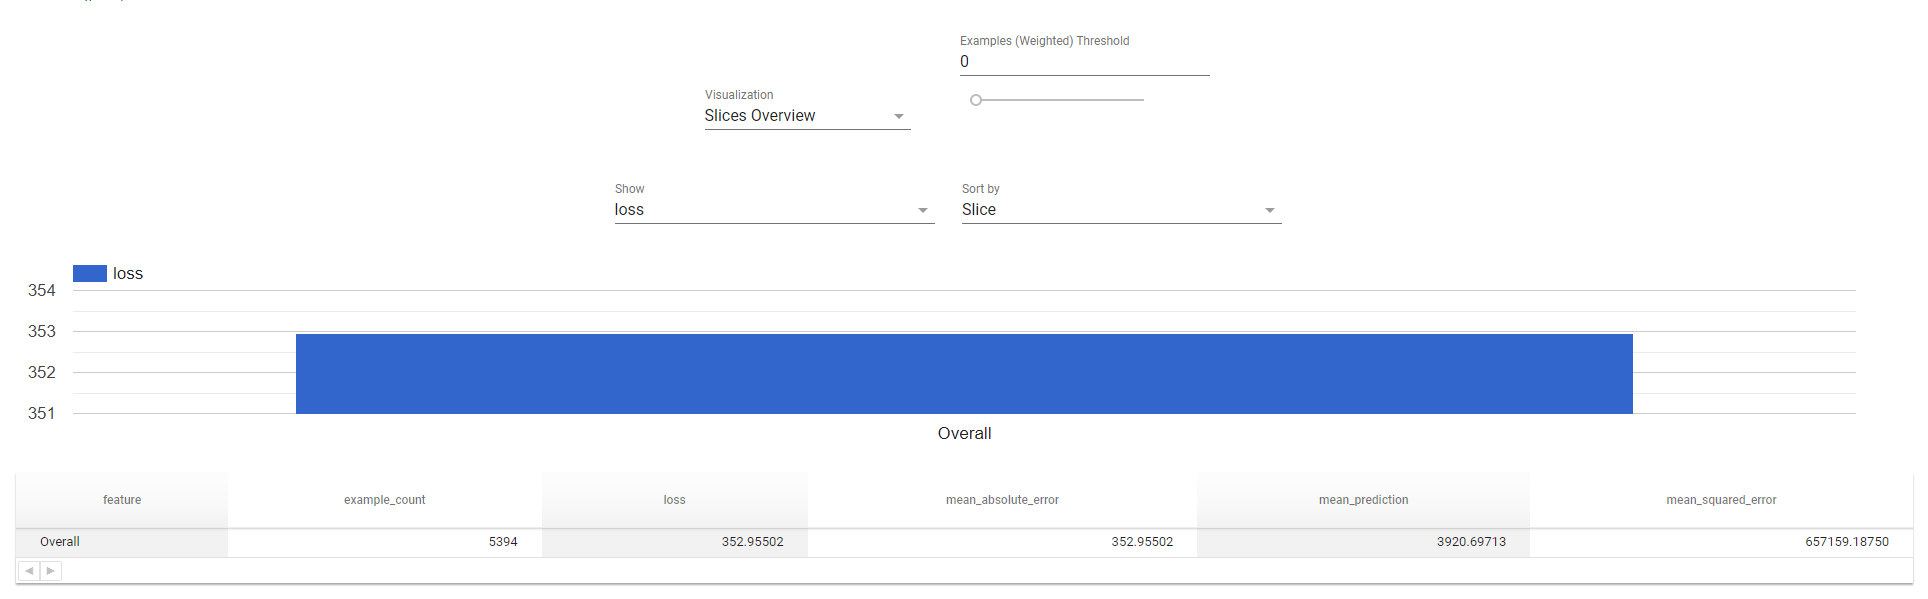

## Compare multiple models

You can compare the performance of multiple models to select the best candidate to use in production. With Apache Beam, you can evaluate and compare multiple models in one step.

### Train a second model

For this use case, train a second model on the full dataset.

In [ ]:
# Preprocess the data.
ds_train_v2 = tfds.load('diamonds', split=['train[:80%]'], as_supervised=True)[0]
train_data_v2 = get_train_data(ds_train_v2)
ds_train_v2 = ds_train_v2.map(transform_data)
ds_train_v2 = ds_train_v2.batch(BATCH_SIZE)

In [ ]:
# Define and train the model.
model_v2 = construct_model('model_v2', train_data_v2)
history = model_v2.fit(
    ds_train_v2,
    validation_data=ds_test,
    epochs=5,
    verbose=1)

In [ ]:
# Save the model to a file.
model_path_v2 = 'saved_model_v2'
model_v2.save(model_path_v2)

### Evaluate the model
The following code demonstrates how to compare the two models and then visualize the results.

In [ ]:
# Define the TFMA evaluation configuration, including two model specs for the two models being compared.
eval_config_compare = text_format.Parse("""
  ## Model information
  model_specs {
    name: "model_v1"
    # For keras (and serving models), add a `label_key`.
    label_key: "output"
    is_baseline: true
  }
  model_specs {
    name: "model_v2"
    # For keras (and serving models), add a `label_key`.
    label_key: "output"
  }

  ## This post-training metric information is merged with any built-in
  ## metrics from training.
  metrics_specs {
    metrics { class_name: "ExampleCount" }
    metrics { class_name: "MeanAbsoluteError" }
    metrics { class_name: "MeanSquaredError" }
    metrics { class_name: "MeanPrediction" }
  }

  slicing_specs {}
""", tfma.EvalConfig())

In [ ]:
from tfx_bsl.public import tfxio

output_path_compare = 'evaluation_results_compare'

eval_shared_models = [
  tfma.default_eval_shared_model(
      model_name='model_v1',
      eval_saved_model_path=model_path_v1,
      eval_config=eval_config_compare),
  tfma.default_eval_shared_model(
      model_name='model_v2',
      eval_saved_model_path=model_path_v2,
      eval_config=eval_config_compare),
]

tfx_io = tfxio.TFExampleRecord(
          file_pattern=tfrecord_file,
          raw_record_column_name=tfma.ARROW_INPUT_COLUMN)

# Run the evaluation.
with beam.Pipeline() as pipeline:
    _ = (
        pipeline
        | 'ReadData' >> tfx_io.BeamSource()
        | 'EvalModel' >> tfma.ExtractEvaluateAndWriteResults(
           eval_shared_model=eval_shared_models,
           eval_config=eval_config_compare,
           output_path=output_path_compare))

Use the following code to create a visualization of the results. By default, the visualisation displays one time series, which is the evolution of the size of the validation set.
To add more interesting visualisations, you can select **add metric series**, and choose to visualise the loss and mean absolute error.

In [ ]:
# Visualize the results.
results = tfma.load_eval_results(output_paths=output_path_compare)
tfma.view.render_time_series(results)

The following image displays an example of a visualisation that evaluates multiple models:

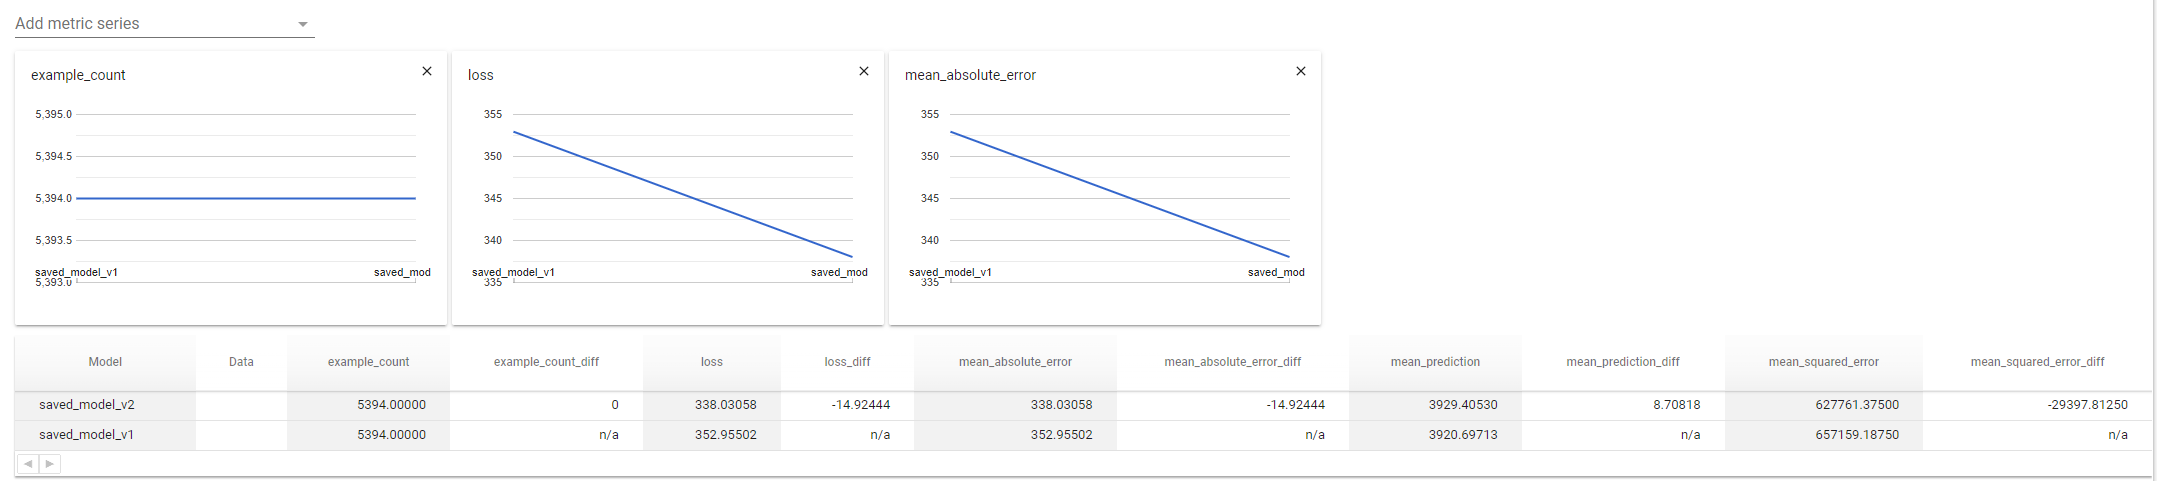